<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-pr-team/blob/main/TabuVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instal modules

In [42]:
!apt-get update
!apt-get install -y tesseract-ocr tesseract-ocr-eng tesseract-ocr-ces
!wget https://github.com/tesseract-ocr/tessdata/raw/main/osd.traineddata -P /usr/share/tesseract-ocr/4.00/tessdata/
!pip install pytesseract opencv-python pillow numpy scikit-image
!pip install pdf2image
!apt-get install -y poppler-utils
!pip install ultralytics

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 3s (96.3 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lis

## Download files from cloud

In [43]:
!pip install gdown

# Sdílený odkaz na složku Drive
shared_folder_url = "https://drive.google.com/drive/folders/1iv-WoXXZHMABZWwk4y3YCojuTmzGbYkh?usp=drive_link"

# ID složky (získáno z odkazu sdílení)
folder_id = "1iv-WoXXZHMABZWwk4y3YCojuTmzGbYkh"

# Stažení složky pomocí gdown
!gdown --folder "$folder_id" -O TabuVision

# Zobrazení stažených souborů
!ls TabuVision


Retrieving folder contents
Retrieving folder 1WbVKrqp0kH6LBtOvkjdrieBmdr0bI5ZZ backend
Retrieving folder 1RhYIdCLR2A7dRbCY246IMjbO4JTy2Qwq app
Retrieving folder 1-g54gqAISXPr7KGXulvjB0ft_-fZV6G1 __pycache__
Processing file 1l1KpEHyXAdSZ1ce9ABh1rJ3ZoUOkoIWN Table.cpython-312.pyc
Processing file 1w0u9r1JIE254xEAM7-DeJZYLUI0w4JmN Table.py
Retrieving folder 1zp3HpeLNIgv8RZJ1skaizxRWRPKrQZtP TableDetection_utils
Retrieving folder 1FGhWnCmo2GjbQQSVPhmJKoZ79BeEcXJ7 __pycache__
Processing file 1i1n6ZwFuG1Tn-V-WVrEixzXj5jM8jjfM SkewDetection.cpython-312.pyc
Processing file 1XxuKTejJLYJ_F0H8fyslFFLD5WT8GKxJ RotateDetection.py
Processing file 18oyK1ggdr2m3AzhiDaUGsiUJQHPMA3ja SkewDetection.py
Retrieving folder 1ZOo1vV1A5tRWuCEch0HMhZSvv3uwv_xw utils
Retrieving folder 1FpcQkPxITaznMrXI8-QAJ68THu6Ykohj __pycache__
Processing file 16tHFnN-B41avVCNG_8pjQfv2K0HOWi1i TableExtractor.cpython-312.pyc
Processing file 1CTlLqHBNRwy5Hl9i8-b3G1bGbIj-4Al5 utils.cpython-312.pyc
Processing file 1cuZVGVcKgriUDaYAA

In [44]:
import json
import sys
import os
sys.path.append('TabuVision')

# Load config file
output_file = 'TabuVision/config/config.json'

if os.path.exists(output_file):
    with open(output_file, 'r') as json_file:
        data = json.load(json_file)
else:
    raise FileNotFoundError(f"Configuration file '{output_file}' is missing. Please ensure it exists in the expected location.")

# Updating values
data['tesseract_exec_location'] = '/usr/bin/tesseract'
data['tessdata_location'] =  '/usr/share/tesseract-ocr/4.00/tessdata/'

# Uložení změn zpět do JSON souboru
with open(output_file, 'w') as json_file:
    json.dump(data, json_file, indent=4)


# TabuVision
## TabuVision demo
Following block is only a copy of TabuVision.py

In [45]:
from backend.utils.TableExtractor import TableExtractorCluster, extract_cells
from backend.TableDetection import TableDetection
from backend.StructureDetection import StructureDetection
from backend.ContentDetection import ContentDetection
from PIL import Image
from pathlib import Path
from backend.utils.utils import PDFFormatToPIL, clean_dir_files
import os


class TabuVision:
    def __init__(self, format: str, debug: bool = False):
        """
        TabuVision class handles table transformation pipeline. It primarily uses classes from backed folder.
        :param format: output format of the extracted tables.
        :param debug: boolean flag whether to print logs, show log images and other information.
        """

        # Initialize models or other attributes as needed
        self.debug = None
        self.table_name = None
        self.TableDetectionUnit = TableDetection(debug=debug)
        self.StructureDetectionUnit = StructureDetection(debug=debug)
        self.ContentDetectionUnit = ContentDetection(debug=debug)

        # Initialize table extractor
        self.TableExtractorClusterUnit = TableExtractorCluster(debug=debug)

        # Set attributes
        self.allowed_suffix_image = ['.jpeg', '.jpg', '.png']
        self.cache_subdir = 'cache'
        self.output_dir = 'output'
        self.cache_dir = f'{self.output_dir}/{self.cache_subdir}'
        self.format = format

        # Set allowed file formats
        # In case of adding new formats, you only need to specify the file suffix and
        # provide a function that takes a file_path as input and returns a list of PIL.Image objects.
        PDFToImage = PDFFormatToPIL(debug=debug)
        self.allowed_suffix_others = {'.pdf': PDFToImage}

        # Clean cache and output dirs
        self.setup_dirs()

    def __call__(self, filepath: str, table_name: str):
        """
        Run method which starts tables extraction.

        :param filepath: filepath of the file to be processed.
        :return: extracted tables if given format.
        """
        return self.run(filepath, table_name)

    def setup_dirs(self):
        """
        Setup cache and output directories.
        """

        # Create or clean output dir
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
        else:
            clean_dir_files(self.output_dir)

        # Create or clean cache dir
        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)
        else:
            clean_dir_files(self.cache_dir)

    def run(self, filepath: str, table_name: str = 'table'):
        """
        Run file extraction and pass it to table extraction pipeline.
        :param table_name: name of the table to be processed (optional).
        :param filepath: filepath of the file to be processed.
        :return: list of extracted tables in given format.
        """

        # Extract page images from file
        images = self.extract(filepath)

        if len(images) == 0:
            print(f'No tables found for file {filepath}!')
            return None

        # Pass images to extraction pipeline
        output_list = []
        page_idx = 1
        for image in images:
            self.table_name = f'{table_name}_{page_idx}'
            html_table = self.to_pipeline(image)

            if html_table is not None:
              output_list.append(html_table)
              page_idx += 1

        return output_list

    def to_pipeline(self, page_img: Image = None):
        """
        Complete pipeline of processing image of the page and extracting tables.

        :param page_img: Input image of the page.
        :return: list of extracted tables in given format.
        """

        # Process an image
        #

        # Step 1: Detect the tables
        table_images = self.TableDetectionUnit.to_pipeline(page_img)

        if len(table_images) == 0:
            print('No tables detected!')
            return None

        # Analyse structure of each table
        table_idx = 1
        processed_table_list = []

        for table_img in table_images:

            # Step 2: Detect table structure and return predicted objects (class, bbox)
            predicted_objects = self.StructureDetectionUnit.to_pipeline(table_img)

            # Step 3: Retrieve table from predicted objects
            if len(predicted_objects) != 0:
                table_object = self.TableExtractorClusterUnit(predicted_objects, f'{self.table_name}_{table_idx}', image_size=table_img.size)
            else:
                print(f'No structure detected in table #{table_idx}!')
                continue

            if table_object is None:
                continue

            # Print detected table structure
            if self.debug:
                table_object.plot_table(image=table_img)

            # Step 3: Extract cell content
            # Detects content of each cell using OCR.
            # Parameter 'fill_on_error' indicates whether cell image should be retrieved when OCR detection fails.
            table_object = extract_cells(
                table_img,
                table_object,
                mode='ocr',
                fill_on_error=True,
                ContentDetectionUnit=self.ContentDetectionUnit,
                log_progress=True
            )

            # Step 4: Build table in given format out of general table object.
            if self.format == 'html':
                table_html = table_object.to_html(output_dir=self.output_dir, cache_subdir=self.cache_subdir, file_name=f'{self.table_name}_{table_idx}')
                processed_table_list.append(table_html)

            table_idx += 1

        return processed_table_list

    def extract(self, file_path: str):
        """
        Extract pages from a file in format of PIL.Image list. Valid file formats can be either images or more
        complex files (containing more pages) - for example PDF file.

        :param file_path: path to the file to be
        extracted. :return: list of pages in PIL.Image format.
        """

        file_path = Path(file_path)
        file_suffix = file_path.suffix.lower()

        # Image file
        if file_suffix in self.allowed_suffix_image:
            if self.debug:
                print(f"Processing image file: {file_path}")

            image = Image.open(file_path)
            return [image]

        # Other file types
        elif file_suffix in self.allowed_suffix_others.keys():
            try:
                transformation_func = self.allowed_suffix_others[file_suffix]
                images = transformation_func(file_path)
                return images

            except Exception as e:
                print(f'During extracting file with suffix {file_suffix} following error occurred: {e}.')
                return None

        else:
            raise ValueError(f"Unsupported file type: {file_path.suffix}")


In [74]:
# *printing HTML code*
from IPython.display import HTML
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_pretty_table(table_html):
    STYLE = """
            <style>
          body {
            font-family: Arial, sans-serif;
            background-color: #f9f9f9;
            margin: 20px;
          }

          table {
            max-width: 780px;
            border-collapse: collapse;
            margin: 20px 0;
            background-color: white;
            box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);
            border-radius: 8px;
            overflow: hidden;
          }

          th, td {
            padding: 12px 15px;
            text-align: left;
          }

          th {
            background-color: #f2f2f2;
            color: #333;
            font-weight: bold;
            text-transform: uppercase;
            font-size: 14px;
            border-bottom: 2px solid #e0e0e0;
          }

          tr {
            border-bottom: 1px solid #e0e0e0;
          }

          tr:nth-of-type(even) {
            background-color: #f9f9f9;
          }

          td {
            color: #555;
            font-size: 14px;
          }

          caption {
            margin-bottom: 10px;
            font-size: 18px;
            font-weight: bold;
            color: #333;
          }
        </style>
        """
    display(HTML(STYLE+' '+table_html))

def print_pages(filepath, single_image=False):
  if single_image:
    pages = [mpimg.imread(filepath)]
  else:
    # Převod PDF na obrázky
    pages = convert_from_path(filepath, 300)

  # Počet stránek
  num_pages = len(pages)

  # Počet obrázků na řádek (2)
  cols = 2
  rows = (num_pages + 1) // cols  # Pokud je neparní počet stránek, bude přidán jeden řádek navíc

  # Nastavení velikosti obrázků pro zobrazení
  figsize = (16, rows * 8)  # Zvětšení výšky podle počtu řádků

  # Zobrazení všech stránek v několika řádcích
  plt.figure(figsize=figsize)

  for i, page in enumerate(pages):
      plt.subplot(rows, cols, i + 1)  # Rozdělení do subgrafů (2 obrázky na řádek)
      plt.imshow(page)
      plt.axis('off')  # Skrytí os
      plt.title(f'Page {i + 1}')

  plt.tight_layout()
  plt.show()



## Lets initialize TabuVision
Just specify table's output format.

In [ ]:
TabuVisionApp = TabuVision(
        format='html'
)

# Adjusting paths as the script is executed outside the program’s root directory.
TabuVisionApp.output_dir = 'TabuVision/output'

## TabuVision can extract table from an image ...

In [72]:
test_img_filepath = 'TabuVision/TestIMGs/test_2.png'

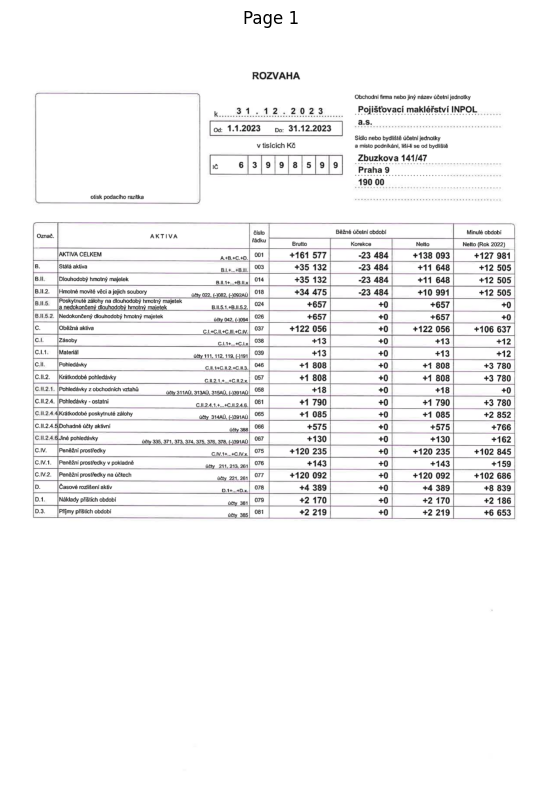

In [73]:
print_pages(test_img_filepath, single_image=True)

In [ ]:
output_list = \
    TabuVisionApp(
        filepath=test_img_filepath,
        table_name='tabuvision_demo'
    )

Analyzing cells: 100%|██████████| 176/176 [00:54<00:00,  3.23it/s]

HTML byl úspěšně uložen do souboru: TabuVision/output/tabuvision_demo_1_1.html


In [ ]:
table_idx = 1
for page in output_list:
    for table_html in page:
        print(f'Extracted table #{table_idx}:')
        display_pretty_table(table_html)
        print('\n\n')
        table_idx += 1

Extracted table #1:





Extracted table #2:





Extracted table #3:





Extracted table #4:





Extracted table #5:





Extracted table #6:





Extracted table #7:


## ... Or process whole PDF

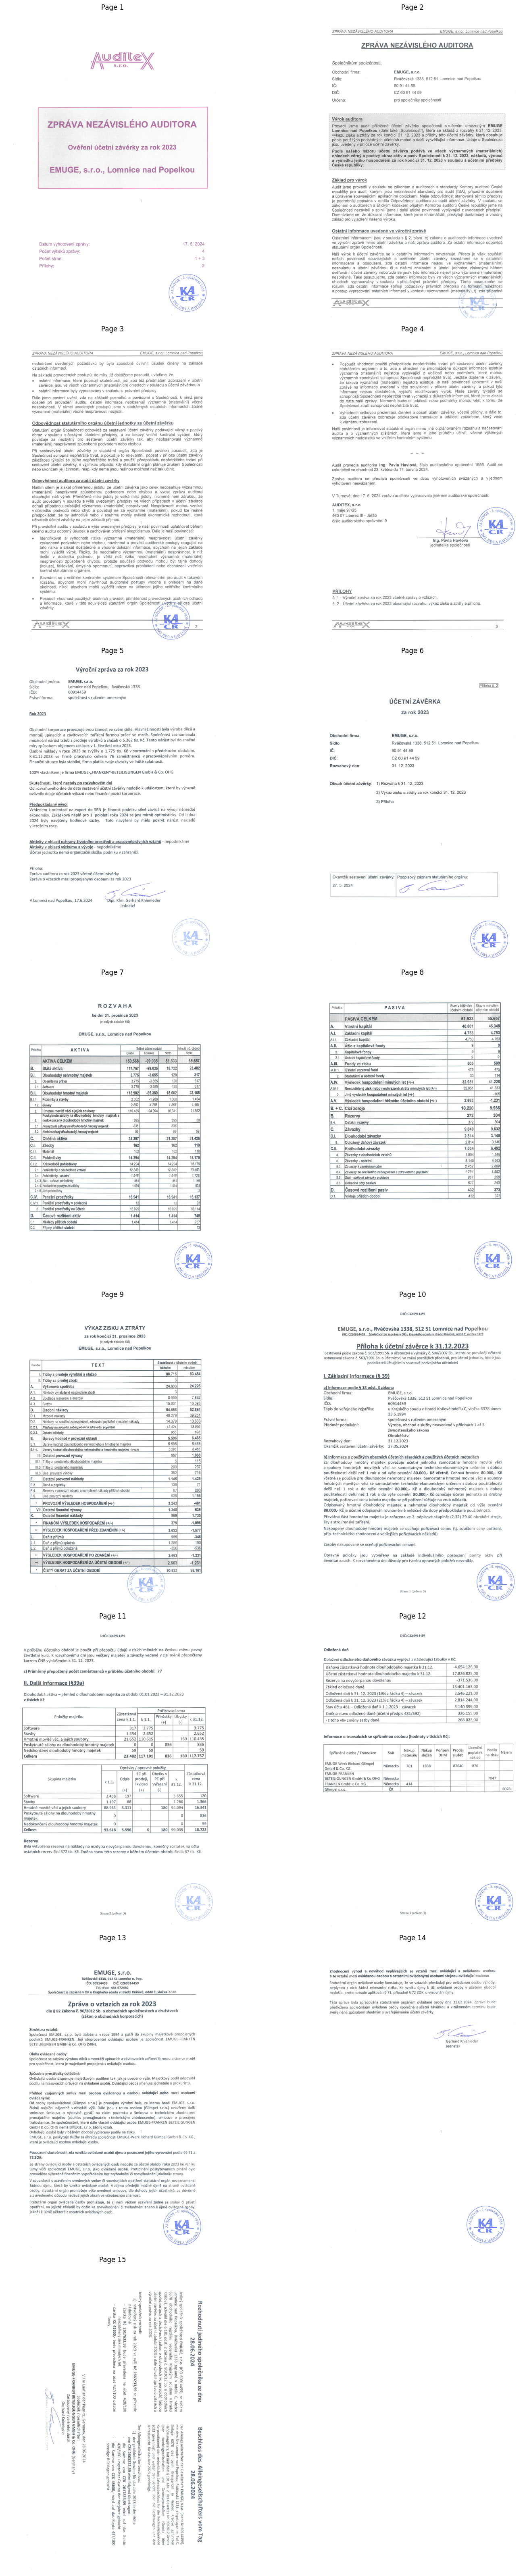

In [75]:
test_pdf_filepath = 'TabuVision/TestPDFs/test_1.pdf'
print_pages(test_pdf_filepath)

In [ ]:
output_list = \
    TabuVisionApp(
        filepath=test_pdf_filepath,
        table_name='tabuvision_demo'
    )

No tables detected!
No tables detected!
No tables detected!
No tables detected!
No tables detected!
No tables detected!


In [ ]:
table_idx = 1
for page in output_list:
    for table_html in page:
        print(f'Extracted table #{table_idx}:')
        display_pretty_table(table_html)
        print('\n\n')
        table_idx += 1

Extracted table #1:





Extracted table #2:





Extracted table #3:





Extracted table #4:





Extracted table #5:





Extracted table #6:





Extracted table #7:
